In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from answers import expectation, ucb, run_ucb_expt
from common import generate_bandit_dataset

%matplotlib inline

# Multi Armed Bandits

## Resources

- Chapter 3 of [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/)
- Chapter 2 of [Sutton & Barto - Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf).

## When is classical hypothesis testing not enough?

In classical hypothesis testing we
- run an experiment, collecting a dataset of A & B
- perform a hypothesis test on observed effects (differences between A and B)

There are a few problems with this
- we only compare two options (one of which is usually a default)
- we might lose money by showing customers a suboptimal option 
- the hypothesis test only shows us if an observed effect is unlikely, not if the effect is large
- in a real business, there is no 'experiment over' date
- the real world is non-stationary - the results we collect might be from a distribution that is changing

We want an experiment where we can **take advantage of the results as we learn** - not have to wait until the experiment results can be used

In a business context we are not concerned with statistical significance - we are (often) concerned with optimizing money as quickly as possible

## The mulit-armed bandit

Bandits allow
- testing multiple options at once
- reach conclusions faster

The term bandit comes from slot machines 
- one armed bandits for their ability to extract money from gamblers

The goal of a multi armed bandit problem is to win as much money as possible
- this is the same as figuring out which arm is best as quick as possible

Bandits are a simplification of the full reinforcement learing problem

## Exploration versus exploitation

Favourite restaurant or somewhere new?
- if you know all the restaurants well, trust your judgement
- if you don't, just randomly pick

## Reinforcement learning context

Bandits share in common with reinforcement learning
- exploration versus exploitation problem (which arm to pull)
- potentially non-stationary

Is supervised learning we use data learn a function to use for prediction on unseen data
- in a bandit problem we could predict the expected value of each arm
- this is **prediction** / evaluation

Use data (the results we get from pulling an arm) to select an action
- this is **control**

We can define the value of an action (pulling a specific arm) as an expectation
- the expected reward of an action

$q_{*}(a) = \mathbb{E}[r(a)]$

Reinforcement learning has a **convenient goal** - maximizing expected reward
- if we did know the true expectation of each action, maximization is an argmax

The bandit problem is one step short of the full reinforcement learning problem
- the bandit is a single state, no transitions of state happen

## Example

You have the following results from comparing different landing pages:

In [2]:
params, results = generate_bandit_dataset(arms=20, samples=3)

results

{'0': [3.2858017902970236, 12.083189226273435, 3.9805822512457185],
 '1': [10.066502149238072, 14.221031572038052, 11.779338983317063],
 '2': [14.440936232072064, 9.349207821890246, 12.353062777950633],
 '3': [16.827372626012608, 11.007322332882627, 18.048536401533077],
 '4': [13.258063218575218, 15.913702094060907, 13.248883537552269],
 '5': [36.448590412267905, 20.41029297998412, 11.434180481066196],
 '6': [30.427040651410564, 11.061341529404531, 24.611030928981165],
 '7': [20.416916500497667, 21.80896927064079, 25.170805905115923],
 '8': [30.231640940958822, 27.628679657818296, 26.31128370690849],
 '9': [27.855160894438153, 23.584256410806795, 26.3362438353519],
 '10': [26.531582014728716, 41.4280109032164, 34.425155596137984],
 '11': [30.917403331206522, 33.569744317196054, 32.66852781169808],
 '12': [33.56542652963262, 36.79725195636628, 37.84892143316182],
 '13': [44.90149751322413, 30.580034143325676, 34.867218222210106],
 '14': [42.24423086159517, 47.63272933501728, 35.46607439

## Practical 

Write a function to take an expectation over the results
- one number for each arm

In [3]:
# answer
expectation(results)

{'0': 6.449857755938726,
 '1': 12.022290901531063,
 '2': 12.047735610637647,
 '3': 15.294410453476104,
 '4': 14.14021628339613,
 '5': 22.764354624439406,
 '6': 22.03313770326542,
 '7': 22.46556389208479,
 '8': 28.057201435228535,
 '9': 25.925220380198947,
 '10': 34.12824950469437,
 '11': 32.38522515336689,
 '12': 36.070533306386906,
 '13': 36.782916626253304,
 '14': 41.78101152981008,
 '15': 34.65398707307345,
 '16': 48.75963129279264,
 '17': 47.056086282134004,
 '18': 51.691831127581644,
 '19': 49.426413170779995}

One approach would be to conclude that one of the arms is optimal and send all our users there
- this is a **greedy** solution to the exploration & exploitation dilemma

## Practical

Take a greedy action based on the results
- take the argmax across expected reward

The problem with a greedy strategy is that we might have noise in our samples that
- our expectation has variance

## Question to class

Is the expectation above biased?

## epsilon-greedy

Another solution would be to favour the option that appears optimal, while still sampling from the options that appear sub-optimal.

A simple algorithm to tackle the exploration-exploitation dilemma is known as **epsilon-greedy** - it is the method used for exploration in DeepMind's 2013 DQN.

The algorithm has a single parameter $\epsilon$, which controls how greedy we are.  

- $\epsilon$ = 1 -> standard A/B test
- $\epsilon$ = 0 -> greedy

In reinforcement learning $\epsilon$ is often decayed from 1 to a 0.05 over an agents lifetime.  Proper selection of $\epsilon$ depends on
- how accurate your greedy estimate is
- how non-stationary the process is

The basic algorithm is as follows:

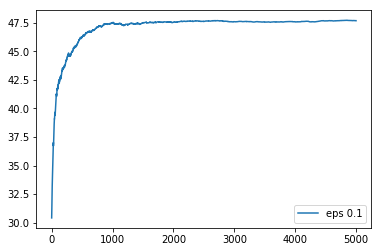

In [4]:
def get_performance(results):
    d = []
    for arm, data in results.items():
        d.extend(data)
    return np.mean(d)

results = {
    arm: list(np.random.normal(*stats))
    for arm, stats in params.items()
}

eps = 0.1
choices = list(params.keys())

steps = 5000
values = np.zeros((steps, len(choices)))
actions = np.empty((steps)).astype(str)
eps_performance = np.zeros(steps)

for step in range(steps):
    prob = np.random.rand()
    if prob < eps:
        strat = 'random'
        action = np.random.choice(choices)

    else:
        strat = 'greedy'
        expectations = expectation(results)
        values[step, :] = list(expectations.values())
        action = max(expectations, key=expectations.get)
        
    actions[step] = action
    
    p = params[action]
    results[action].append(float(np.random.normal(p.loc, p.scale, 1)))
    eps_performance[step] = get_performance(results)
    
plt.plot(eps_performance, label='eps {}'.format(eps))
_ = plt.legend()

#TODO put min & max lines of arms


## Upper Confidence Bound (UCB)

2.7 in [Sutton & Barto - Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf)

Select an action based on it's historical mean + an exploration bonus

$a = \underset{x}{\text{argmax}} \left[ q(a) + c \cdot \sqrt{\frac{\ln t}{N(a)}} \right] $

$t$ = timestep

$N(a)$ = number of times action $a$ taken

## Practical

Implement a function that performs a UCB update

In [5]:
c = 0.5
# answer
ucb(results, step, c)

{'0': 10.273913287407838,
 '1': 12.843363350429518,
 '2': 14.666006063279706,
 '3': 16.075008269848635,
 '4': 16.968774062158456,
 '5': 22.538054493081816,
 '6': 20.561717876277847,
 '7': 25.24475159004208,
 '8': 27.279680394725855,
 '9': 28.81436602729014,
 '10': 32.73304087366401,
 '11': 33.22259473363141,
 '12': 35.417693517876735,
 '13': 34.81674328439648,
 '14': 37.490595854209786,
 '15': 44.39062675309795,
 '16': 43.6884226472542,
 '17': 46.057264867766676,
 '18': 48.62244598390119,
 '19': 50.19934554779485}

## Practical

Implement a UCB experiment

In [6]:
# answer
ucb_performance = run_ucb_expt(5)

plt.plot(eps_performance, label='eps') 
plt.plot(ucb_performance, label='ucb')
_ = plt.legend()

NameError: name 'params' is not defined